In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from rasterio.windows import Window
from rasterio.transform import xy
import os
import geopandas as gpd
import glob
import random
import pandas as pd
from rembg import remove
import cv2
import time

## Fusion imports
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Concatenate, Input
from tensorflow.keras.models import Model




OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
path1 = os.path.abspath('../')
path_ATL03 = os.path.join(path1, "IS2_LSTM")
path_s2 = os.path.join(path1, "S2_tif")
path_csv = os.path.join(path1, "csv")
path_before_training = os.path.join(path1, "Before_training")
print(path_s2)

/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/S2_tif


# Important functions

In [3]:
def color_segmentation(img):
    # Get a "mask" over the image for each pixel
    # if a pixel's color is between the lower and upper white, its mask is 1
    # Otherwise, the pixel's mask is 0
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    lower_ice = (0, 0, 205)#(127, 7, 94) #increase v to specify ow
    upper_ice = (185, 255, 255)#(147, 53, 232) #increase h to specify si
    mask_ice = cv2.inRange(hsv_img, lower_ice, upper_ice)
    
    lower_tice = (0, 0, 31)#(127, 7, 94) #increase v to specify ow
    upper_tice = (185, 255, 204)#(147, 53, 232) #increase h to specify si
    mask_tice = cv2.inRange(hsv_img, lower_tice, upper_tice)
    
    lower_water = (0, 0, 0)#(127, 7, 94) #increase v to specify ow
    upper_water = (185, 255, 30)#(147, 53, 232) #increase h to specify si
    mask_water = cv2.inRange(hsv_img, lower_water, upper_water)
    
    # duplicate the image
    seg_img = img.copy()
    #color each masked portion
    seg_img[mask_ice == 255] = [255, 0, 0]
    seg_img[mask_tice == 255] = [0, 0, 255]
    seg_img[mask_water == 255] = [0, 255, 0]
    
    #seg_img = cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB)
    
    return seg_img

def shadow_cloud_removal(ori):

    ### seperate open water
    lower_water = (0, 0, 0)
    upper_water = (185, 255, 30)
    hsv_img = cv2.cvtColor(ori, cv2.COLOR_RGB2HSV)
    mask_water = (cv2.inRange(hsv_img, lower_water, upper_water))

    # duplicate the image
    without_water_img = ori.copy()
    without_water_img[mask_water == 255] = [255, 255, 255]
    #plot_image(ori, water_img)

    #img = cv2.imread('s2_vis_2.png',cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(without_water_img, cv2.COLOR_RGB2GRAY)

    dilated_img = cv2.dilate(img, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 155)
    diff_img = 255 - cv2.absdiff(img, bg_img)

    ret2, outs2 = cv2.threshold(src = diff_img, thresh = 0, maxval = 255, type = cv2.THRESH_OTSU+cv2.THRESH_BINARY)
    diff_img2 = cv2.bitwise_and(diff_img, outs2)

    norm_img = cv2.normalize(diff_img2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    _, thr_img = cv2.threshold(norm_img, 235, 0, cv2.THRESH_TRUNC)
    thr_img = cv2.normalize(thr_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

    ### seperate thin and old ice
    old_thin_ice = cv2.cvtColor(thr_img,cv2.COLOR_GRAY2RGB)
    hsv_img = cv2.cvtColor(old_thin_ice, cv2.COLOR_RGB2HSV)

    lower_tice = (0, 0, 0)
    upper_tice = (185, 255, 204)
    mask_tice = cv2.inRange(hsv_img, lower_tice, upper_tice)

    lower_ice = (0, 0, 205)
    upper_ice = (185, 255, 255)
    mask_ice = cv2.inRange(hsv_img, lower_ice, upper_ice)
    mask_ice = cv2.bitwise_xor(mask_water, mask_ice)
    #plot_image3(mask_water, mask_tice, mask_ice)

    # duplicate the image
    shadow_free = old_thin_ice.copy()
    #color each masked portion
    shadow_free[mask_ice == 255] = [255, 255, 255]
    shadow_free[mask_tice == 255] = [155, 155, 155]
    shadow_free[mask_water == 255] = [0, 0, 0]
    shadow_free = cv2.cvtColor(shadow_free, cv2.COLOR_BGR2RGB)
    #plot_image(shadow_free, ori)

    #segmentation
    #img = cv2.cvtColor(water_img,cv2.COLOR_GRAY2RGB)
    seg_img = color_segmentation(ori)
    #plot_image(ori, seg_img, title_1 = "Original Image", title_2 = "Segmented original image")

    #final = cv2.cvtColor(shadow_free,cv2.COLOR_GRAY2RGB)
    seg_res = color_segmentation(shadow_free)
    #gray = cv2.cvtColor(seg_res,cv2.COLOR_RGB2GRAY)
    #plot_image(shadow_free, seg_res, title_1 = "Shadow free Image", title_2 = "Segmented shadow free image")
    
    #return seg_img, shadow_free, seg_res
    return seg_res
        

In [4]:
# Define file paths
tiff_files = ['s2_vis_00_20191103T183459_20191103T183502_T05CMR.tif', 's2_vis_01_20191103T183459_20191103T183502_T05CMS.tif']


# Get list of TIFF files
tiff_files = sorted(glob.glob(os.path.join(path_s2, "*.tif")))

# Get list of CSV files
csv_files = sorted(glob.glob(os.path.join(path_csv, "*.csv")))

# Select two random CSV files
selected_csv_files = random.sample(csv_files, 2)

# ATL03 to S2 mapping file
atl03_to_s2_mapping_file = pd.read_csv(os.path.join(path1, "ATL03_S2_2019-11-01_2019-11-30_ross.csv"))


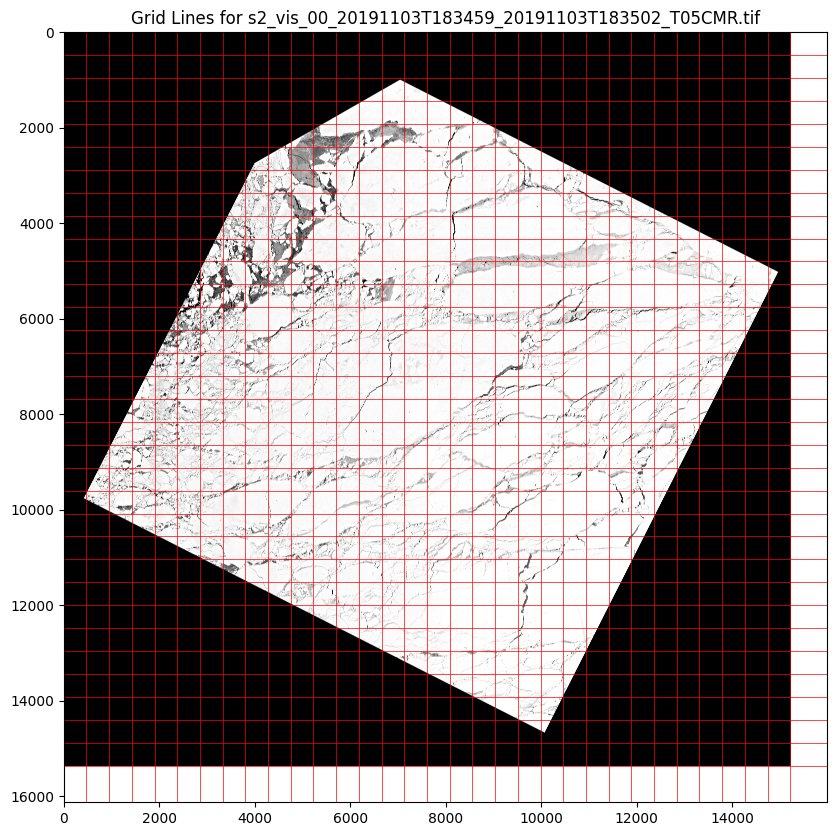

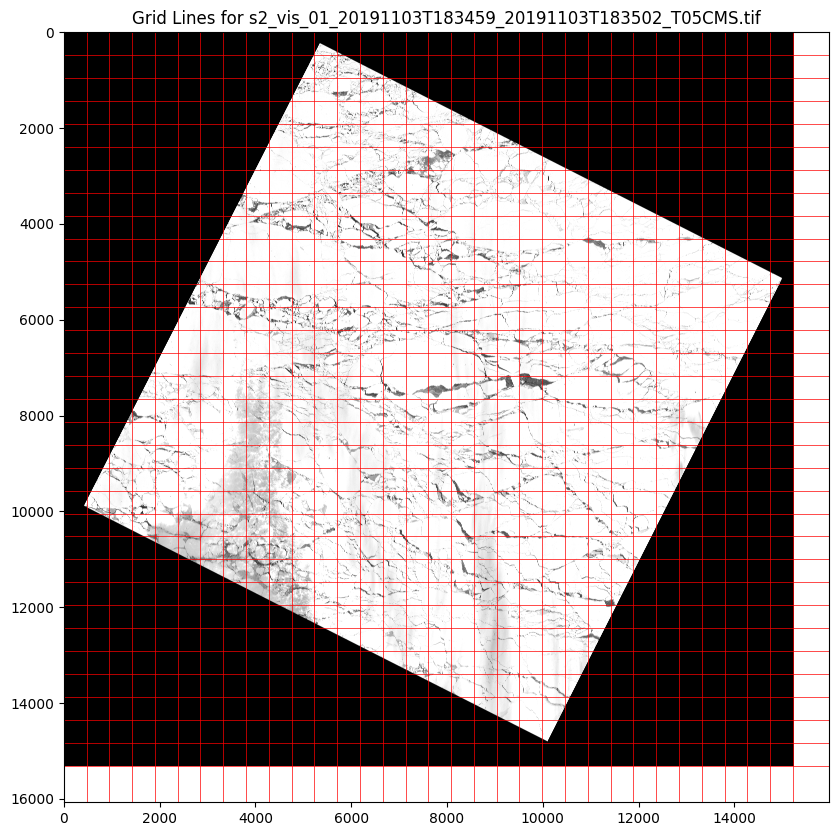

In [5]:
# Show 32x32 Grid Lines (Work on first two files only)
for file in tiff_files[:2]:
    with rasterio.open(file) as img:
        width, height = img.width, img.height
        transform = img.transform

        # Generate grid lines
        x_coords = np.linspace(0, width, 33)
        y_coords = np.linspace(0, height, 33)

        # Plot grid lines
        plt.figure(figsize=(10, 10))
        plt.imshow(img.read(1), cmap='gray')
        for x in x_coords:
            plt.axvline(x, color='red', linewidth=0.5)
        for y in y_coords:
            plt.axhline(y, color='red', linewidth=0.5)
        plt.title(f'Grid Lines for {os.path.basename(file)}')
        plt.show()


In [6]:

def read_csv_if_exists(file):
    print(file)
    if os.path.exists(file) and os.path.isfile(file):
        return pd.read_csv(file)
    return None

# Function to get coordinates list
def get_coordinates_list(file):
    file = os.path.basename(file)[10:-4]
    general_atl_file_prefix_name = atl03_to_s2_mapping_file[atl03_to_s2_mapping_file['S2_id'] == "COPERNICUS/S2_SR/" + file]['IS2_file'].values[0][:-9]

    df_gt1r = pd.DataFrame()
    df_gt2r = pd.DataFrame()
    df_gt3r = pd.DataFrame()

    alt03_gt1r_file = os.path.join(path_csv, general_atl_file_prefix_name + "gt1r.csv")
    alt03_gt2r_file = os.path.join(path_csv, general_atl_file_prefix_name + "gt2r.csv")
    alt03_gt3r_file = os.path.join(path_csv, general_atl_file_prefix_name + "gt3r.csv")

    df_gt1r = read_csv_if_exists(alt03_gt1r_file)
    df_gt2r = read_csv_if_exists(alt03_gt2r_file)
    df_gt3r = read_csv_if_exists(alt03_gt3r_file)
    df = pd.concat([df_gt1r, df_gt2r, df_gt3r])
    coordinates_list = list(zip(df['lat'], df['lon']))

    return coordinates_list  # List of coordinates

In [19]:
import matplotlib
# matplotlib.use('Agg')  # Use non-interactive backend
matplotlib.use('TkAgg')
fig, ax = plt.subplots(figsize=(8, 8))

def plot_grid_and_coordinates(file):
    img = rasterio.open(file, crs='EPSG:3976')

    raw = img.read(1)
    raw[raw < 0] = 0

    ori = img.read()
    ori[ori < 0] = 0
    ori = ori.swapaxes(0, 1)
    ori = ori.swapaxes(1, 2)

    img_array = shadow_cloud_removal(ori)
    img_array[img_array < 0] = 0
    # img_array = remove(img_array)
    # img_array = rgba2rgb(img_array, background=(0, 0, 0)) 

    height = img_array.shape[0]
    width = img_array.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(img.transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)
    print("xs.shape: ", xs.shape)

    # Convert coordinates to GeoDataFrame
    coordinates_list = get_coordinates_list(file)
    df = pd.DataFrame(coordinates_list, columns=['lat', 'lon'])
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
    gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

    # Transform to match the image's CRS
    gdf = gdf.to_crs('epsg:3976')
    
    # Extract transformed coordinates
    gdf['x'] = gdf.geometry.apply(lambda x: x.x)
    gdf['y'] = gdf.geometry.apply(lambda x: x.y)

    # Filter coordinates to match the image's coordinate bounds
    df = pd.DataFrame(gdf)
    x_min = xs.min()
    x_max = xs.max()
    y_min = ys.min()
    y_max = ys.max()
    df = df[(df["x"] >= x_min) & (df["x"] <= x_max) & (df["y"] >= y_min) & (df["y"] <= y_max)]

    # Map coordinates to pixel indices
    pixel_coords = [img.index(x, y) for x, y in zip(df['x'], df['y'])]

    # Generate grid lines
    x_coords = np.linspace(0, width, 33)
    y_coords = np.linspace(0, height, 33)

    # Plot grid lines and coordinates
    # fig, ax = plt.subplots(figsize=(8, 8))
    plt.imshow(img_array, cmap='gray')
    plt.vlines(x_coords, 0, height, color='red', linewidth=0.5)
    plt.hlines(y_coords, 0, width, color='red', linewidth=0.5)

    rows, cols = zip(*pixel_coords)
    plt.scatter(cols, rows, color='blue', s=2)

    plt.title(f'Grid Lines and Coordinates for {os.path.basename(file)}')
    # output_path = os.path.join(path1, f'grid_images/{os.path.basename(file)}_grid_coordinates_with_tracks.png')
    # plt.savefig(output_path)
    plt.show()
    # plt.close(fig)


# Plot grid lines and coordinates for the first two files
for file in tiff_files[:2]:
    plot_grid_and_coordinates(file)

xs.shape:  (233733120,)
/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt1r.csv
/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt2r.csv
/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt3r.csv
xs.shape:  (233018376,)
/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt1r.csv
/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt2r.csv
/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt3r.csv


In [ ]:
# # Show 32x32 Grid Lines and plot coordinates
# for file in tiff_files[:2]:  # Process only the first two TIFF files for illustration
#     img = rasterio.open(file, crs='EPSG:3976')

#     raw = img.read(1)
#     raw[raw < 0] = 0

#     ori = img.read()
#     ori[ori < 0] = 0
#     ori = ori.swapaxes(0, 1)
#     ori = ori.swapaxes(1, 2)

#     img_array = shadow_cloud_removal(ori)
#     img_array[img_array < 0] = 0
#     # img_array = remove(img_array)
#     # img_array = rgba2rgb(img_array, background=(0, 0, 0)) 

#     height = img_array.shape[0]
#     width = img_array.shape[1]
#     cols, rows = np.meshgrid(np.arange(width), np.arange(height))
#     xs, ys = rasterio.transform.xy(img.transform, rows, cols)
#     xs = np.array(xs)
#     ys = np.array(ys)
#     print("xs.shape: ", xs.shape)

#     # Convert coordinates to GeoDataFrame
#     coordinates_list = get_coordinates_list(file)
#     df = pd.DataFrame(coordinates_list, columns=['lat', 'lon'])
#     gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
#     gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

#     # Transform to match the image's CRS
#     gdf = gdf.to_crs('epsg:3976') 

    
#     # Extract transformed coordinates
#     gdf['x'] = gdf.geometry.apply(lambda x: x.x)
#     gdf['y'] = gdf.geometry.apply(lambda x: x.y)

#     # Filter coordinates to match the image's coordinate bounds
#     df = pd.DataFrame(gdf)
#     x_min = xs.min()
#     x_max = xs.max()
#     y_min = ys.min()
#     y_max = ys.max()
#     df = df[(df["x"] >= x_min) & (df["x"] <= x_max) & (df["y"] >= y_min) & (df["y"] <= y_max)]

#     # Map coordinates to pixel indices
#     pixel_coords = [img.index(x, y) for x, y in zip(df['x'], df['y'])]

#     # Generate grid lines
#     x_coords = np.linspace(0, width, 33)
#     y_coords = np.linspace(0, height, 33)

#     # Plot grid lines and coordinates
#     plt.figure(figsize=(8, 8))
#     plt.imshow(img_array, cmap='gray')
#     for x in x_coords:
#         plt.axvline(x, color='red', linewidth=0.5)
#     for y in y_coords:
#         plt.axhline(y, color='red', linewidth=0.5)

#     # Plot coordinates
#     for row_idx, col_idx in pixel_coords:
#         plt.scatter(col_idx, row_idx, color='blue', s=10)

#     plt.title(f'Grid Lines and Coordinates for {os.path.basename(file)}')
#     plt.show()


xs.shape:  (233733120,)
/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt1r.csv
/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt2r.csv
/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt3r.csv


KeyboardInterrupt: 

In [ ]:

# # Show 32x32 Grid Lines (Work on first two files only)
# for file in tiff_files[:2]:
#     with rasterio.open(file) as img:
#         width, height = img.width, img.height
#         transform = img.transform

#         # Generate grid lines
#         x_coords = np.linspace(0, width, 33)
#         y_coords = np.linspace(0, height, 33)

#         # Plot grid lines
#         plt.figure(figsize=(10, 10))
#         plt.imshow(img.read(1), cmap='gray')
#         for x in x_coords:
#             plt.axvline(x, color='red', linewidth=0.5)
#         for y in y_coords:
#             plt.axhline(y, color='red', linewidth=0.5)
#         plt.title(f'Grid Lines for {os.path.basename(file)}')
#         plt.show()

# Function to save 32x32 images
# def save_32x32_images(file, coords, output_dir):
#     with rasterio.open(file) as img:
#         # Convert coordinates to GeoDataFrame
#         df = pd.DataFrame(coords, columns=['lat', 'lon'])
#         gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
#         gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
        
#         # Transform to match the image's CRS
#         gdf = gdf.to_crs(img.crs)
        
#         # Extract transformed coordinates
#         gdf['x'] = gdf.geometry.apply(lambda x: x.x)
#         gdf['y'] = gdf.geometry.apply(lambda x: x.y)
        
#         # Map coordinates to pixel indices
#         for i, row in gdf.iterrows():
#             x, y = row['x'], row['y']
#             row_idx, col_idx = img.index(x, y)
            
#             # Define window
#             window = Window(col_idx - 16, row_idx - 16, 32, 32)
            
#             # Read window
#             img_array = img.read(window=window)
            
#             # Save as PNG
#             output_path = os.path.join(output_dir, f'{os.path.basename(file)}_{i}.png')
#             plt.imsave(output_path, img_array[0], cmap='gray')
#             print(f'Saved {output_path}')

# # Output directory
# output_directory = 'output_images'
# os.makedirs(output_directory, exist_ok=True)

# # Save 32x32 images for each file
# for file in tiff_files[:2]:
#     save_32x32_images(file, coordinates_list, output_directory)

# MMDL Fusion stage

**The MMDL Fusion stage is the final stage of the MMDL pipeline. It takes the predictions of the MMDL models and combines them to produce the final prediction**

### Load the MMDL models

In [6]:
from tensorflow.keras.models import load_model

# Load U-Net and LSTM models
# unet_model_path = load_model('lstm_model.keras')
# lstm_model_path = load_model('s2_multi_with_cloud_auto_labeled_50.keras')


## Perform Late Fusion using Concatenation

## Technique: Additive Fusion (Concatenation)

In [ ]:
from tensorflow.keras.layers import Concatenate, Dense
from tensorflow.keras.models import Model

# Late fusion: Concatenate the outputs of the U-Net and LSTM
combined = Concatenate()([unet_model_path.output, lstm_model_path.output])
# Fully connected layers for classification
dense1 = Dense(64, activation='relu')(combined)
output = Dense(3, activation='softmax')(dense1)  # Assuming 3 classes

# Create the late fusion model
late_fusion_model = Model(inputs=[unet_model.input, lstm_model.input], outputs=output)

## Technique: Multiplicative Fusion

## Technique: Gated Fusion

In [ ]:

# Load the saved U-Net and LSTM models
unet_model = load_model(unet_model_path)
lstm_model = load_model(lstm_model_path)

# Ensure both models have compatible output shapes
# If necessary, adjust the shapes (flatten, reshape) to match
unet_output = unet_model.output
lstm_output = lstm_model.output

# Create gating mechanisms for both modalities
# The gates are learned weights that control the contribution of each modality
gate_unet = Dense(unet_output.shape[-1], activation='sigmoid')(unet_output)
gate_lstm = Dense(lstm_output.shape[-1], activation='sigmoid')(lstm_output)

# Weight the original outputs by their respective gates
gated_unet_output = Multiply()([unet_output, gate_unet])
gated_lstm_output = Multiply()([lstm_output, gate_lstm])

# Combine the gated outputs
fused_output = Add()([gated_unet_output, gated_lstm_output])

# Add fully connected layers for classification after the fusion
dense1 = Dense(64, activation='relu')(fused_output)
output = Dense(3, activation='softmax')(dense1)  # Assuming 3 classes

# Create the final gated fusion model
gated_fusion_model = Model(inputs=[unet_model.input, lstm_model.input], outputs=output)

# Compile the model
gated_fusion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
gated_fusion_model.summary()

## Technique: Nonlinear Fusion

In [ ]:

# Load the saved U-Net and LSTM models
unet_model = load_model(unet_model_path)
lstm_model = load_model(lstm_model_path)

# Ensure both models have compatible output shapes
# If necessary, adjust the shapes (flatten, reshape) to match
unet_output = unet_model.output
lstm_output = lstm_model.output

# Nonlinear fusion: Use a neural network to learn the combination of the two modalities
# Concatenate the features from both modalities
combined_features = Concatenate()([unet_output, lstm_output])

# Pass the concatenated features through multiple dense layers to learn nonlinear interactions
fusion_layer = Dense(128, activation='relu')(combined_features)
fusion_layer = Dense(64, activation='relu')(fusion_layer)
fusion_layer = Dense(32, activation='relu')(fusion_layer)

# Final classification layer
output = Dense(3, activation='softmax')(fusion_layer)  # Assuming 3 classes

# Create the final nonlinear fusion model
nonlinear_fusion_model = Model(inputs=[unet_model.input, lstm_model.input], outputs=output)

# Compile the model
nonlinear_fusion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Technique: Attention-Based Mechanism